In [201]:
## Ex7 - 25/10/2021
    # Valerio Lionetti 
    # Loris Onori
    # Alessio di Dio
    # LeonardoSerilli
    
## Written using Gurobi solver

In [202]:
import networkx as nx
import gurobipy as gb
import matplotlib.pyplot as plt
import random
from itertools import combinations, chain, groupby

In [203]:
################## Drawing Functions ##################

def draw(G):
    pos = nx.shell_layout(G)
    
    edge_lab = {(u,v):[0, G[u][v]['capacity']] for u,v in G.edges()}

    plt.figure(figsize=(6,6))
    nx.draw_networkx_edge_labels (G, pos, edge_labels=edge_lab)
    nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="black", node_size=500)

def drawFlow(G, x):
    pos = nx.shell_layout(G)
    
    edge_lab = {(u,v):[int(x[u,v].x), G[u][v]['capacity']] for u,v in G.edges()}
    activated_edge = [i for i in G.edges() if x[i].x > 1E-3]
    not_activated_edge = [i for i in G.edges() if x[i].x <= 1E-3]
    
    plt.figure(figsize=(6,6))
    nx.draw_networkx_edges (G, pos, edgelist=activated_edge, edge_color='r')
    nx.draw_networkx_edges (G, pos, edgelist=not_activated_edge, edge_color='b')
    nx.draw_networkx_edge_labels (G, pos, edge_labels=edge_lab)
    nx.draw_networkx_labels (G,pos)
    nx.draw(G, pos, with_labels=True, alpha=0.0, node_color="lightblue", node_size=500)

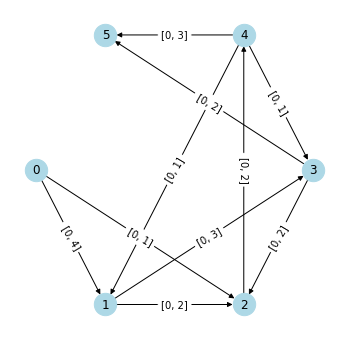

In [204]:
################## Build The Graph ##################

G = nx.DiGraph()

s = 0
t = 5

nodes = [0, 1, 2, 3, 4, 5]
edges = [(0,1), (0,2), (1,2), (1,3), (2,4), (3,2), (3,5), (4,1), (4,3), (4,5)]
capacities = [4, 1, 2, 3, 2, 2, 2, 1, 1, 3]

G.add_nodes_from(nodes)

for i in range(len(edges)):
    G.add_edge(edges[i][0], edges[i][1], capacity=capacities[i])

draw(G)

In [205]:
maxFlow = gb.Model()

################## Variables and Objective function ##################

x = maxFlow.addVars(G.edges(), 
                    vtype=gb.GRB.CONTINUOUS, 
                    name='x')

maxFlow.setObjective(x.sum(s, G.out_edges(s)), gb.GRB.MAXIMIZE)

maxFlow.update()
maxFlow.write('maxFlow.lp')

In [206]:
################## Constraints ##################

# Balance Constraints
for i in G.nodes():
    if(i!=s and i!=t):
        maxFlow.addConstr((x.sum(i, G.out_edges(i)) - (x.sum(G.in_edges(i), i)) == 0), 
                           name='Balance')

# Capacity Constraints
maxFlow.addConstrs(((x[i,j] <= G.edges[i,j]['capacity'] ) for i,j in G.edges()), 
                   name='Capacity')

maxFlow.update()
maxFlow.write('maxFlow.lp')

In [207]:
maxFlow.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 14 rows, 10 columns and 26 nonzeros
Model fingerprint: 0x4e9f4ba3
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 10 rows and 1 columns
Presolve time: 0.00s
Presolved: 4 rows, 9 columns, 15 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.0000000e+00   7.000000e+00   0.000000e+00      0s
       4    4.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective  4.000000000e+00



----------------------------Found Optimal OPT----------------------------
Obj: 4
x[0,1]=3 x[0,2]=1 x[1,2]=1 x[1,3]=2 x[2,4]=2 x[3,5]=2 x[4,5]=2 

----------------------------Gurobi maxflow model OPT----------------------------
Obj: 4 
Flow {0: {1: 3, 2: 1}, 1: {2: 0, 3: 3}, 2: {4: 2}, 3: {2: 1, 5: 2}, 4: {1: 0, 3: 0, 5: 2}, 5: {}}


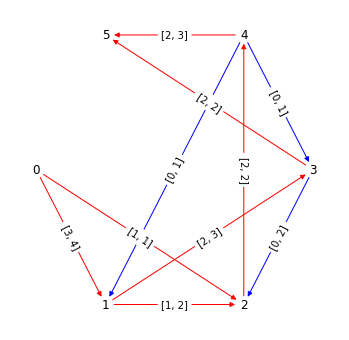

In [208]:
print("\n----------------------------Found Optimal OPT----------------------------")
print('Obj: %g' % maxFlow.objVal)

for v in maxFlow.getVars():
    if v.x > 1E-3:
        print ('%s=%g' % (v.varName, v.x), end = ' ')

drawFlow(G, x)

print("\n\n----------------------------Gurobi maxflow model OPT----------------------------")
value, flow = nx.maximum_flow(G, s, t)
print("Obj:", value, "\nFlow", flow)